In [22]:
import pandas as pd


df = pd.read_csv('datasets/adult/adult-cleaned.csv')

Y = df['target']
B = df['capitol_gain']
X = df.drop(['target', 'capitol_gain'], axis=1)
X.shape

(45222, 37)

In [2]:
Y_pos = Y[Y == 1]
Y_neg = Y[Y != 1]

X_pos = X.loc[Y_pos.index]
X_neg = X.loc[Y_neg.index]

B_pos = B.loc[Y_pos.index]
B_neg = B.loc[Y_neg.index]

print(X_pos.shape, Y_pos.shape, B_pos.shape)
print(X_neg.shape, Y_neg.shape, B_neg.shape)

(11208, 37) (11208,) (11208,)
(34014, 37) (34014,) (34014,)


In [6]:
B_pos_test = B_pos[(B_pos == 0) | (B_pos == 99999)]
B_neg_test = B_neg[(B_neg == 0) | (B_neg == 99999)]
B_pos_train = B_pos[(B_pos != 0) & (B_pos != 99999)]
B_neg_train = B_neg[(B_neg != 0) & (B_neg != 99999)]

print(B_pos_test.shape, B_pos_train.shape)
print(B_neg_test.shape, B_neg_train.shape)

(9062,) (2146,)
(32599,) (1415,)


In [7]:
X_pos_test = X_pos.loc[B_pos_test.index]
X_neg_test = X_neg.loc[B_neg_test.index]
X_pos_train = X_pos.loc[B_pos_train.index]
X_neg_train = X_neg.loc[B_neg_train.index]
Y_pos_test = Y_pos.loc[B_pos_test.index]
Y_neg_test = Y_neg.loc[B_neg_test.index]
Y_pos_train = Y_pos.loc[B_pos_train.index]
Y_neg_train = Y_neg.loc[B_neg_train.index]

print(X_pos_test.shape, Y_pos_test.shape, B_pos_test.shape)
print(X_neg_test.shape, Y_neg_test.shape, B_neg_test.shape)
print(X_pos_train.shape, Y_pos_train.shape, B_pos_train.shape)
print(X_neg_train.shape, Y_neg_train.shape, B_neg_train.shape)

(9062, 37) (9062,) (9062,)
(32599, 37) (32599,) (32599,)
(2146, 37) (2146,) (2146,)
(1415, 37) (1415,) (1415,)


<AxesSubplot: ylabel='Frequency'>

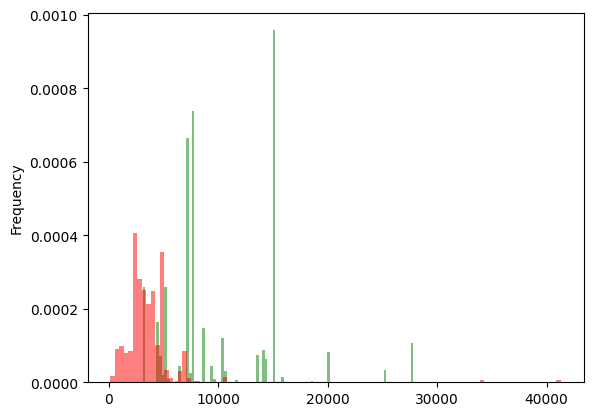

In [9]:
B_pos_train.plot.hist(bins=100, alpha=0.5, density=True, color='g')
B_neg_train.plot.hist(bins=100, alpha=0.5, density=True, color='r')

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def train_and_predict(X_train, B_train, X_test):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

    # Fit the grid search to the data
    grid_search.fit(X_train, B_train)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best R^2: {best_score}")

    best_rf = RandomForestRegressor(**best_params, random_state=42)

    # Fit the model on the training data
    best_rf.fit(X_train, B_train)

    # Predict on the test data
    B_test_pred = best_rf.predict(X_test)
    
    return B_test_pred

In [16]:
B_pos_pred = train_and_predict(X_pos_train, B_pos_train, X_pos_test)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best R^2: 0.1907989865566995


In [17]:
B_neg_pred = train_and_predict(X_neg_train, B_neg_train, X_neg_test)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best R^2: -0.05434574937083965


In [18]:
X_pos_test['budget'] = B_pos_pred
X_pos_test['target'] = Y_pos_test
X_pos_train['budget'] = B_pos_train
X_pos_train['target'] = Y_pos_train

X_neg_test['budget'] = B_neg_pred
X_neg_test['target'] = Y_neg_test
X_neg_train['budget'] = B_neg_train
X_neg_train['target'] = Y_neg_train

df = pd.concat([X_pos_test, X_neg_test, X_pos_train, X_neg_train])
df.to_csv('datasets/adult/adult-imputed-budget-new.csv', index=False)

<AxesSubplot: ylabel='Frequency'>

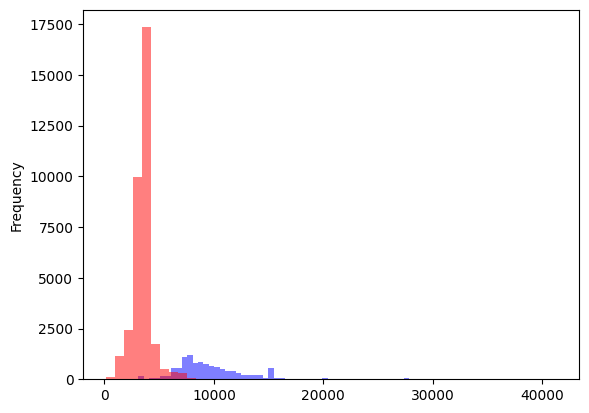

In [19]:
df[df['target'] == 1]['budget'].plot.hist(bins=50, alpha=0.5, color='blue')
df[df['target'] == -1]['budget'].plot.hist(bins=50, alpha=0.5, color='red')

In [ ]:
from data_prep_utils import remove_examples_by_condition

df = pd.read_csv('datasets/adult/adult-imputed-budget-new.csv')

Y = df['target']
B = df['budget']
X = df.drop(['target', 'budget'], axis=1)
X_COLS = ["final_weight", "education_num", "capitol_loss", "hours_per_week", "age"]
X = X[X_COLS]

X, B, Y = remove_examples_by_condition(X, B, Y,
                                       amount_to_leave=0.25, percent=True,
                                       Y_cond=lambda y: y == -1, seed=42)
print(Y.value_counts())

df = X
df['target'] = Y
df['budget'] = B

df[df['target'] == 1]['budget'].plot.hist(bins=50, alpha=0.5, color='blue')
df[df['target'] == -1]['budget'].plot.hist(bins=50, alpha=0.5, color='red')

df.to_csv('datasets/adult/adult-imputed-budget-balanced-new.csv', index=False)